# Visualisation des données de loyers leboncoin

## Importations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Vue d'ensemble

In [2]:
data = pd.read_csv('../data/LoyersFinal.csv')
data['prix_m2'] = data['price'] / data['surface']
data.describe() 

,list_id,price,latitude,longitude,nb_pieces,surface,prix_m2
count,1.194000e+03,1194.00000,1194.000000,1194.000000,1144.000000,1114.000000,1114.000000
mean,2.918886e+09,1065.20268,48.860036,2.338511,1.335664,24.895871,48.216886
std,3.955750e+07,258.24849,0.021235,0.040400,0.837185,10.820512,16.495275
min,1.950691e+09,500.00000,48.817173,2.232957,1.000000,7.000000,7.017544
25%,2.915946e+09,870.00000,48.841562,2.306609,1.000000,17.000000,37.755981
50%,2.927266e+09,1050.00000,48.859156,2.339971,1.000000,24.000000,43.602431
75%,2.932378e+09,1290.00000,48.879336,2.368968,2.000000,32.000000,54.545455
max,2.935284e+09,1500.00000,48.901187,2.462427,23.000000,114.000000,125.000000


## Relations entre toutes les paires de variables

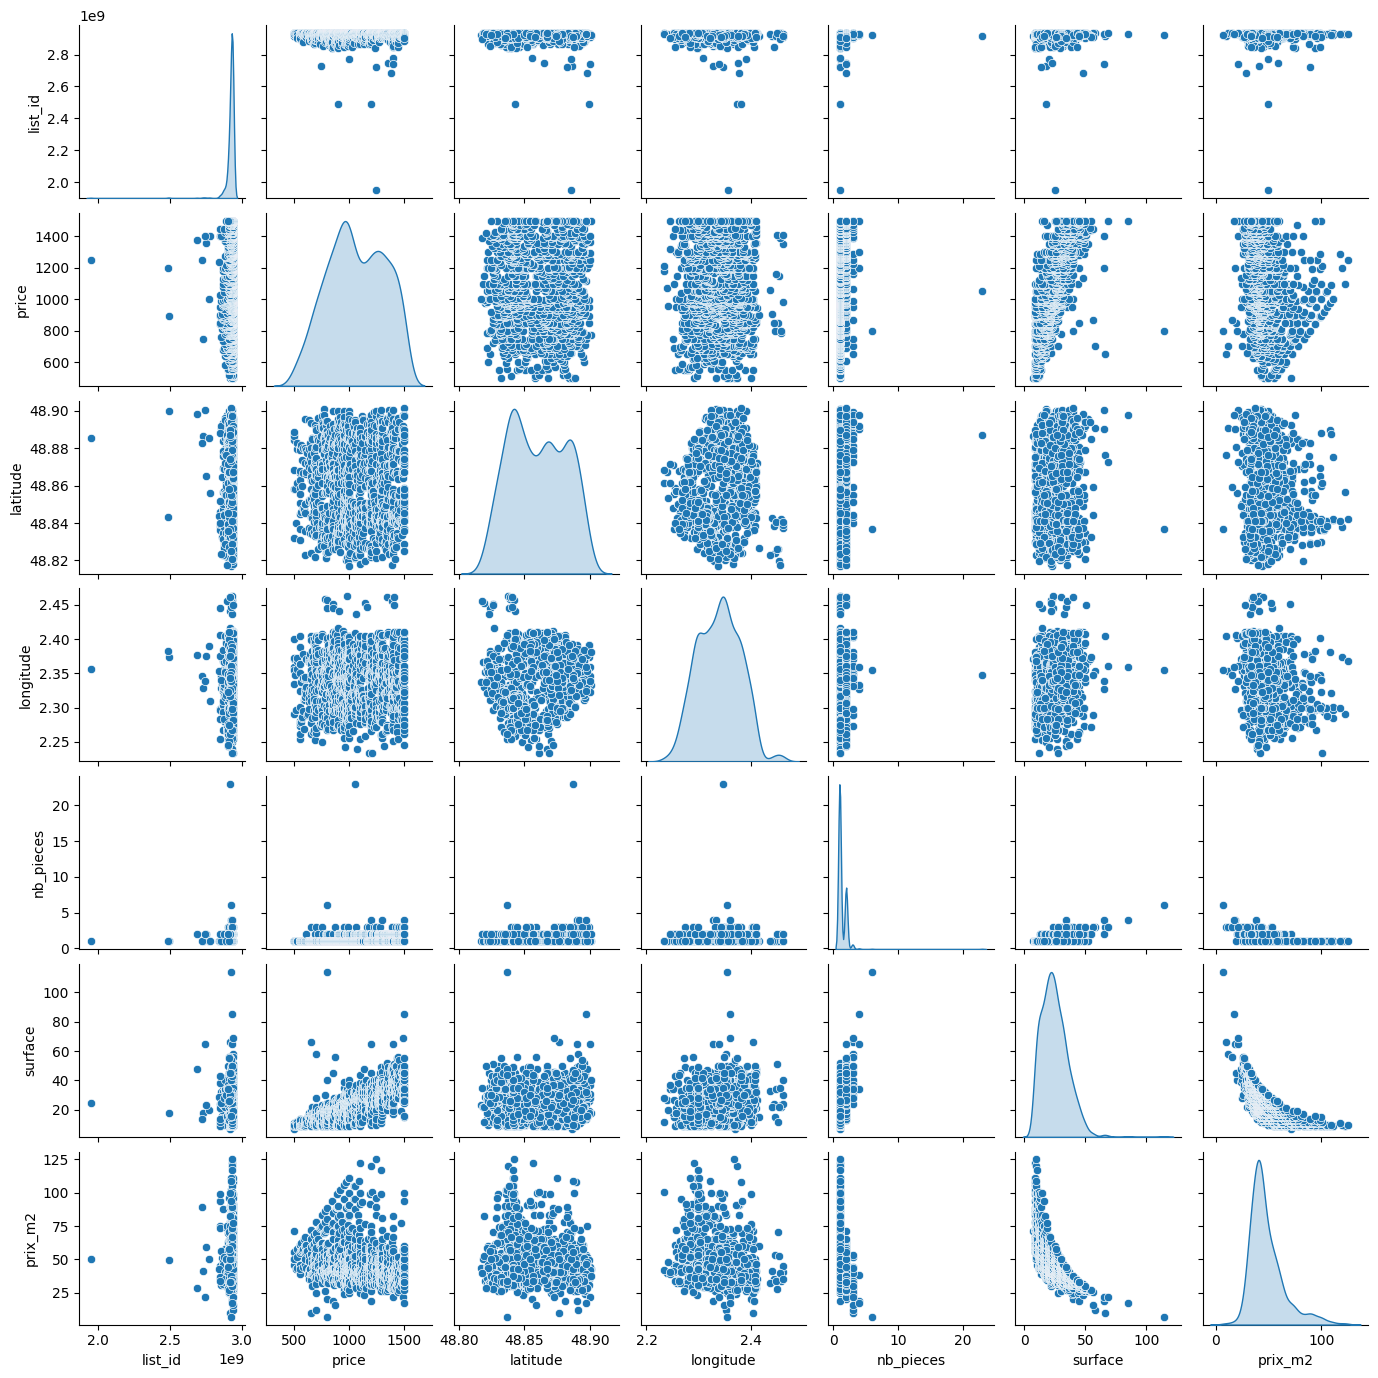

In [3]:
sns.pairplot(data, diag_kind="kde", height=2)  # "kde" pour un histogramme lissé
plt.show()

## Matrice de Correlation

,price,nb_pieces,surface,prix_m2
0,500,1.0,9.0,55.555556
1,500,1.0,11.0,45.454545
2,500,1.0,7.0,71.428571
3,500,1.0,10.0,50.000000
4,500,1.0,9.0,55.555556
...,...,...,...,...
1189,1500,2.0,30.0,50.000000
1190,1500,2.0,45.0,33.333333
1191,1500,2.0,27.0,55.555556
1192,1500,1.0,26.0,57.692308


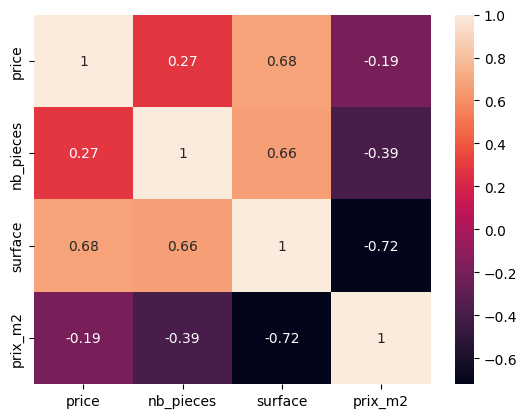

In [4]:
#[ETUD]
data2 = data.drop(['list_id', 'longitude', 'latitude','urls','first_publication_date'], axis=1)
MatCorr = data2.corr()
sns.heatmap(MatCorr, annot=True)
data2

## Analyse en composantes principales

/var/folders/1n/y44nm8wn4d7_c007zc7xn_hh0000gn/T/ipykernel_35870/996942298.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loadings.columns, y=pca.explained_variance_ratio_ * 100, palette="viridis")


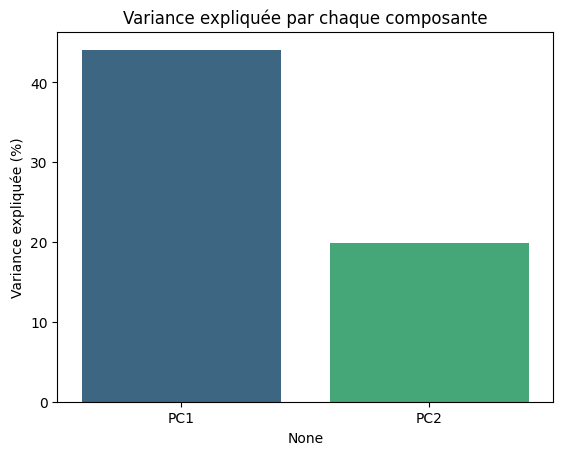

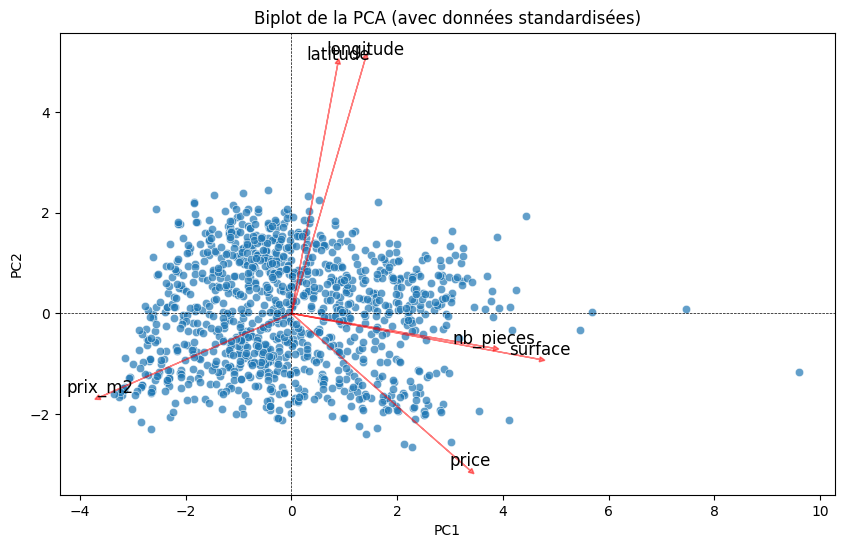

In [ ]:
data3 = data.drop(['list_id','urls','first_publication_date'], axis=1)
data3 = data3.dropna()

# Normaliser les données avant la PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data3)  # Transforme en numpy array

# PCA avec les données normalisées
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2"])

# Extraire les composantes pour le biplot
loadings = pd.DataFrame(pca.components_.T, index=data3.columns, columns=["PC1", "PC2"])

# Afficher la variance expliquée
sns.barplot(x=loadings.columns, y=pca.explained_variance_ratio_ * 100, palette="viridis")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée par chaque composante")
plt.show()

# Tracer le biplot avec les flèches
fig, ax = plt.subplots(figsize=(10, 6))

# Nuage de points des individus
sns.scatterplot(data=data_pca, x="PC1", y="PC2", alpha=0.7, ax=ax)

scale_factor = 8  # Ajuste ce facteur pour mieux voir les flèches
for feature, (x, y) in loadings.iterrows():
    ax.arrow(0, 0, scale_factor * x, scale_factor * y, 
             color='red', alpha=0.5, head_width=0.1, head_length=0.1)
    ax.text(scale_factor * x, scale_factor * y, feature, 
            color='black', fontsize=12, ha="center", va="bottom")

# Ajouter des axes et un titre
ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax.axvline(0, color="black", linestyle="--", linewidth=0.5)
ax.set_title("Biplot de l'ACP (avec données standardisées)")
plt.show()

## Cercle de corrélation

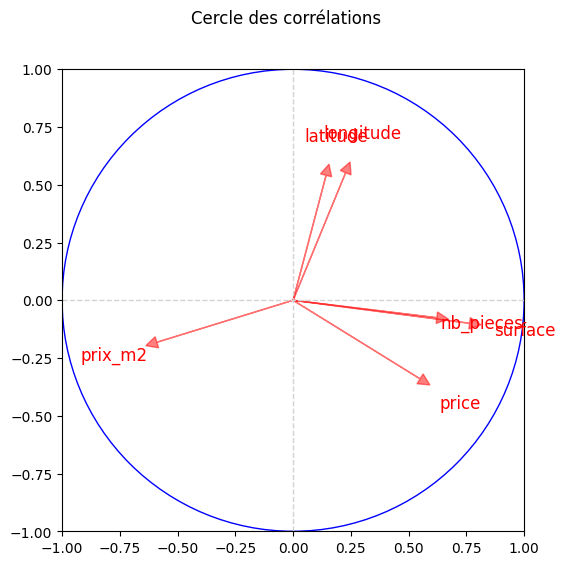

In [6]:
n = data_pca.shape[0]  # Nombre d'individus
p = data_pca.shape[1]  # Nombre de composantes principales
p_original = data3.shape[1]  # Nombre de variables initiales

# Calcul des valeurs propres
eigval = (n-1) / n * pca.explained_variance_
sqrt_eigval = np.sqrt(eigval)

# Correction de la taille de la matrice
corvar = np.zeros((p_original, p))

# Calcul des coordonnées des variables
for k in range(p):
    corvar[:, k] = pca.components_[k, :] * sqrt_eigval[k]

# Création d'un DataFrame avec les coordonnées des variables
coordvar = pd.DataFrame({
    'id': data3.columns,  # Noms des variables initiales
    'COR_1': corvar[:, 0],
    'COR_2': corvar[:, 1]
})

coordvar

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize=(6,6))
fig.suptitle("Cercle des corrélations")

# Définition des limites des axes
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des axes
axes.axvline(x=0, color='lightgray', linestyle='--', linewidth=1)
axes.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)

# Ajout des noms des variables avec un facteur d'échelle pour la lisibilité
scale = 0.8  # Ajuste ce facteur si besoin
for j in range(len(coordvar)):
    x, y = coordvar["COR_1"][j], coordvar["COR_2"][j]
    axes.arrow(0, 0, x* scale, y* scale, color='red', alpha=0.5, 
               head_width=0.05, head_length=0.05)  # Ajout des flèches
    axes.text(x * (scale+0.25), y * (scale+0.25), coordvar["id"][j], color='red', 
              fontsize=12, ha="center", va="center")  # Ajout du texte

# Ajout du cercle unité
cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_patch(cercle)

# Aspect carré pour un cercle bien rond
axes.set_aspect('equal')

plt.show()

## Clustering (par K-Means)

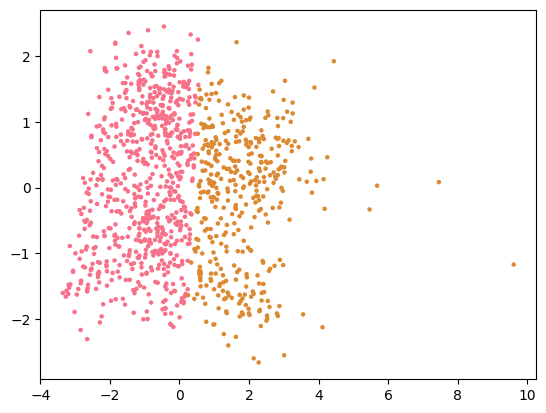

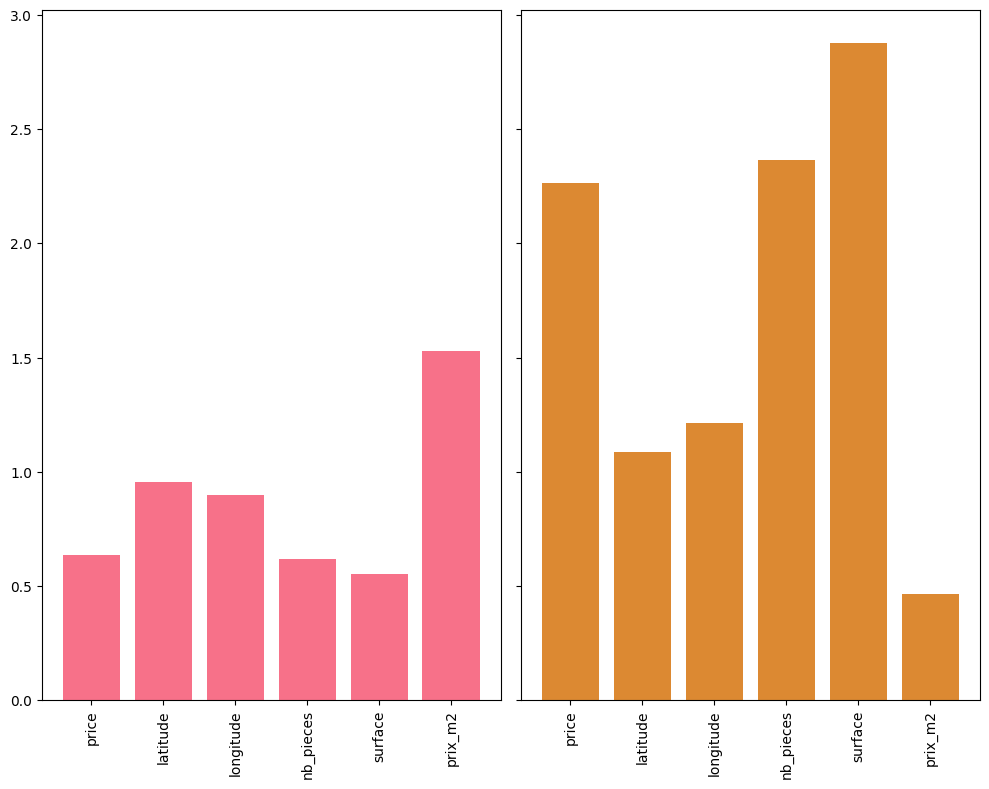

In [7]:
# Palette de couleurs avec 10 couleurs
palette10 = sns.color_palette('husl', 10)

# K-Means avec 8 clusters
km = KMeans(n_clusters=2, random_state=42)
pred = km.fit_predict(data_pca)

#accès aux colonnes
plt.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], color=[palette10[pred[i]] for i in range(len(data_pca))], s=5)

#calcul des centres
real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))

# subplots
fig, axs = plt.subplots(km.n_clusters // 2, 2, figsize=(10, 8), sharey=True, sharex=True)

for i, k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)), k, color=palette10[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(data3.columns, rotation="vertical")

plt.tight_layout()
plt.show()

## Nombre d'appartements par taille pour prix $\in [500,1500]$

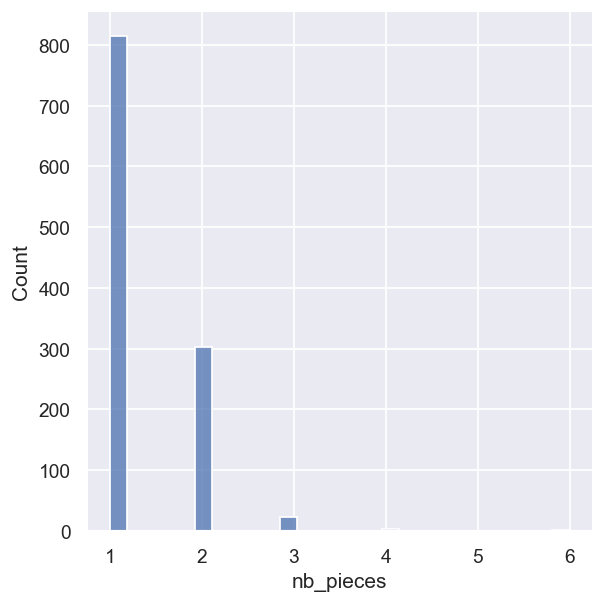

In [8]:
data_pieces = data['nb_pieces'].dropna().astype(int)
data_piecesdf = pd.DataFrame(data_pieces, columns=["nb_pieces"])
data_piecesdf = data_piecesdf[~data_piecesdf["nb_pieces"].isin([23])]
sns.set_theme(rc={"figure.dpi": 125})  
sns.set_style(style="darkgrid")
sns.displot(data_piecesdf, x="nb_pieces", fill=True, edgecolor="white")
plt.show()
data_pieces = data_pieces.unique()


## Heatmap - Density mapbox

In [9]:
import plotly.graph_objects as go

# Créer une heatmap avec Densitymapbox
fig = go.Figure(go.Densitymapbox(
    lon=data["longitude"],
    lat=data["latitude"],
    z=data["prix_m2"],  # Valeurs à afficher
    radius=10,  # Taille des points
    colorscale="Viridis",  # Choisir la palette de couleurs
    colorbar_title="Prix au m²",  # Titre de la barre de couleurs
))

# Configurer la carte
fig.update_geos(
    center=dict(lat=48.8566, lon=2.3522),  # Centre de la carte (Paris)
    projection_type="mercator",
    visible=False
)

# Ajouter un titre
fig.update_layout(
    title="Heatmap des prix au m² des logements à Paris",
    mapbox_style="open-street-map",  # Style sans besoin de token Mapbox
    mapbox_center={"lat": 48.8566, "lon": 2.3522},  # Centrer sur Paris
    mapbox_zoom=11,  # Zoom sur Paris
        width=800,  # Largeur de la carte (en pixels)
    height=600,  # Hauteur de la carte (en pixels)
)

# Afficher la c

- À notre grand étonnement, on remarque que c'est plutôt dans le 15e arrondissement qu'il y a les logements les plus chers.

## Universités et Ecoles à paris

In [10]:
ecoles_paris = pd.read_csv('../data/ecoles_paris.csv')
# Afficher le résultat
ecoles_paris
# ecoles

,identifiant interne,libellé,nom court,sigle,type d'établissement,typologie d'universités et assimilés,secteur d'établissement,vague contractuelle,localisation,site internet,...,Effectifs d'étudiants inscrits 2016-17,Effectifs d'étudiants inscrits 2017-18,Effectifs d'étudiants inscrits 2018-19,Effectifs d'étudiants inscrits 2019-20,Effectifs d'étudiants inscrits 2020-21,Effectifs d'étudiants inscrits 2021-22,Effectifs d'étudiants inscrits 2022-23,coordonnees,longitude,latitude
0,Hq9dm,École nationale supérieure de création industr...,Ensci-Les Ateliers,NaN,École,NaN,public,NaN,Île-de-France>Paris>Paris 8e,https://www.ensci.com/2017-2018-ensci-les-atel...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.369182, 48.858436]",2.369182,48.858436
1,l4myZ,Institut protestant de théologie,IPT,NaN,École,NaN,privé,NaN,Île-de-France>Paris>Paris 14e,http://www.iptheologie.fr/index.php,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.33709, 48.834422]",2.337090,48.834422
2,XBZhH,École nationale supérieure des métiers de l'im...,La Fémis,NaN,École,NaN,public,NaN,Île-de-France>Paris>Paris 18e,http://www.femis.fr/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.342584, 48.890069]",2.342584,48.890069
3,24vIz,Institut national du patrimoine,NaN,Inp,École,NaN,public,NaN,Île-de-France>Paris>Paris 2e,http://www.inp.fr/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.338842, 48.866499]",2.338842,48.866499
4,8bexp,ESCP Business School,NaN,ESCP,École,NaN,privé,NaN,Île-de-France>Paris>Paris 15e,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.317575, 48.842394]",2.317575,48.842394
5,jYUcF,Arts et Métiers Sciences et Technologies,Arts et Métiers,ENSAM,Grand établissement,NaN,public,Vague D,Île-de-France>Paris>Paris 13e,https://artsetmetiers.fr/,...,5742.0,5884.0,5925.0,6030.0,6055.0,5906.0,5830.0,"[2.357558, 48.833773]",2.357558,48.833773
6,TWBzp,Université Paris-Panthéon-Assas,Panthéon-Assas,NaN,Université,Université tertiaire - droit et économie,public,Vague D,Île-de-France>Paris>Paris 5e,http://www.assas-universite.fr/,...,NaN,NaN,NaN,NaN,NaN,22246.0,21695.0,"[2.344888, 48.846806]",2.344888,48.846806
7,QeAil,Ecole Nationale Supérieure des Beaux-Arts de P...,Beaux-Arts de Paris,ENSBA,École,NaN,public,NaN,Île-de-France>Paris>Paris 6e,https://beauxartsparis.fr/fr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-1.568442, 47.228673]",-1.568442,47.228673
8,wp55m,IAE Paris - Sorbonne Business School,IAE de Paris,IAE Paris,École,NaN,public,Vague D,Île-de-France>Paris>Paris 5e,http://www.iae-paris.com/,...,1516.0,1811.0,1767.0,1746.0,1709.0,1937.0,2001.0,"[2.348565, 48.83839]",2.348565,48.838390
9,15kV5,"Institut national du sport, de l'expertise et ...",NaN,INSEP,Grand établissement,NaN,public,NaN,Île-de-France>Paris>Paris 12e,https://www.insep.fr/fr,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.454596, 48.833925]",2.454596,48.833925


## Carte des Université et écoles parisiennes

In [11]:
# Créer la carte avec Scattermapbox pour afficher les écoles
fig = go.Figure(go.Scattermapbox(
    lon=ecoles_paris["longitude"],
    lat=ecoles_paris["latitude"],
    mode="markers",  # Afficher les marqueurs et les textes
    text=ecoles_paris["libellé"],  # Ajouter le nom de chaque école comme label
    textposition="top right",  # Position du label par rapport aux points
    marker=dict(size=12, color="blue", opacity=0.7),  # Apparence des marqueurs
))

# Configurer la carte
fig.update_layout(
    title="Carte des Universités et écoles à Paris",
    mapbox_style="open-street-map",  # Style sans besoin de token Mapbox
    mapbox_center={"lat": 48.8566, "lon": 2.3522},  # Centrer sur Paris
    mapbox_zoom=11,  # Zoom sur Paris
    width=800,  # Largeur de la carte (en pixels)
    height=600,  # Hauteur de la carte (en pixels)
)

# Afficher la carte
fig.show()